<a href="https://colab.research.google.com/github/alinarogova/HW/blob/master/%D0%94%D0%97_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [184]:
import pandas as pd
import torch

## Стовпчики:

Ця таблиця містить інформацію про клієнтів банку та їхні характеристики, які можуть впливати на рішення щодо надання кредиту.

- **age** – Вік клієнта (ціле число).
- **is_working** – Ознака того, чи працює клієнт
- **job** – Тип зайнятості клієнта
- **marital** – Сімейний стан
- **education** – Рівень освіти
- **balance** – Баланс клієнта на банківському рахунку
- **housing** – Чи має клієнт іпотеку
- **loan** – Чи має клієнт активний кредит
- **contact** – Спосіб контакту з клієнтом
- **campaign** – Кількість контактів клієнта до банку
- **poutcome** – Результат попередньої маркетингової кампанії
- **offer** – Чи було клієнту запропоновано кредит
- **credit** – Сума кредиту

In [185]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/refs/heads/main/module3/data/bank.csv')

df.loc[df['offer']=='no', 'credit'] = 0


In [186]:
df.head()

,age,is_working,job,marital,education,balance,housing,loan,contact,campaign,poutcome,offer,credit
0,29,no,technician,single,tertiary,18254,no,no,cellular,2,unknown,no,0
1,26,no,services,single,secondary,512,yes,yes,unknown,3,unknown,no,0
2,30,no,management,single,secondary,135,no,no,cellular,2,unknown,no,0
3,41,no,technician,married,unknown,30,yes,no,cellular,1,unknown,no,0
4,27,no,admin.,single,secondary,321,no,yes,unknown,1,unknown,no,0


Ваша задача побудувати модель, яка використовує класифікацію для визначення чи варто пропонувати кредит клієнту, та регресію для визначення суми кредиту

# Завдання 1
Розділіть дані на 3 частини: `offer`, `credit` та решту стовпчиків(дані клієнта)


In [187]:
df.groupby(by="offer")['offer'].count()

,offer
offer,
no,8901
yes,3965


In [188]:
offer = df['offer']
credit = df['credit']
X = df.drop(columns=['offer', 'credit'])
X

,age,is_working,job,marital,education,balance,housing,loan,contact,campaign,poutcome
0,29,no,technician,single,tertiary,18254,no,no,cellular,2,unknown
1,26,no,services,single,secondary,512,yes,yes,unknown,3,unknown
2,30,no,management,single,secondary,135,no,no,cellular,2,unknown
3,41,no,technician,married,unknown,30,yes,no,cellular,1,unknown
4,27,no,admin.,single,secondary,321,no,yes,unknown,1,unknown
...,...,...,...,...,...,...,...,...,...,...,...
12861,47,yes,technician,married,secondary,1167,yes,no,cellular,1,failure
12862,31,yes,unknown,married,secondary,111,no,no,cellular,2,failure
12863,37,no,unemployed,single,tertiary,1316,yes,no,cellular,1,failure
12864,42,no,management,married,tertiary,479,yes,no,unknown,2,unknown


Виведіть кількості категорій по кожному категоріальному стовпчику, на їх основі визначіть ті категорії яких дуже мало

Змініть препроцесор:
* до обробки числових даних добавте `Quantiletransformer`, це потрібно шоб всі значення були в діаразоні від 0 до 1
* до категоріальної обробки добавте `OneHotEncoder`

In [189]:
columns_names = X.select_dtypes(include='object').columns
for i in columns_names:
  print(X[i].value_counts())


is_working
no     8530
yes    4336
Name: count, dtype: int64
job
management       2857
blue-collar      2571
technician       2141
admin.           1463
services         1043
retired           768
self-employed     454
unemployed        414
entrepreneur      383
student           358
housemaid         334
unknown            80
Name: count, dtype: int64
marital
married     7487
single      3904
divorced    1475
Name: count, dtype: int64
education
secondary    6366
tertiary     4074
primary      1880
unknown       546
Name: count, dtype: int64
housing
yes    6605
no     6261
Name: count, dtype: int64
loan
no     11056
yes     1810
Name: count, dtype: int64
contact
cellular     8754
unknown      3239
telephone     873
Name: count, dtype: int64
poutcome
unknown    10068
failure     1380
success      844
other        574
Name: count, dtype: int64


In [190]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, QuantileTransformer

num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

# числові ознаки
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ('encoder', QuantileTransformer(n_quantiles=100))]
    )

# категоріальні ознаки
cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(min_frequency=800, sparse_output=False))
           ])

# об'єднання двох pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('encoder',
                                                  QuantileTransformer(n_quantiles=100))]),
                                 Index(['age', 'balance', 'campaign'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(min_frequency=800,
                                                                sparse_output=False))]),
                                 Index(['is_working', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'poutcome'],
      dtype='object'))])

# Завдання 2
Підготуйте датасети

Для класифікації візміть усі рядки з таблиці та створіть `dataloader`

In [191]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        self.y = self.y.reshape(-1, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, ind):
        return self.X[ind], self.y[ind]



In [192]:
from sklearn.model_selection import train_test_split

new_offer = offer == 'yes'
new_offer = new_offer.astype('int')
preprocessor.fit(X)
new_X = preprocessor.transform(X)

X_train, X_test, y_train, y_test = train_test_split(new_X, new_offer,
                                                    train_size=0.8,
                                                    random_state=42
                                                    )
X_train.head()
y_train.head()

,offer
11116,0
11335,1
7890,1
6338,0
10035,0


In [193]:
dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

In [194]:
batch_size = 128
offer_train_dl = DataLoader(dataset_train,
                      batch_size=batch_size,
                      shuffle=True,
                      )

offer_test_dl = DataLoader(dataset_test,
                     batch_size=batch_size,
                     shuffle=True,
                     )

Для регресії візьміть дані тих клієнтів, яким запропонували кредит

In [195]:
mask = offer == 'yes'
credit_x = new_X[mask]
credit_y = credit[mask]

In [196]:
X_train, X_test, y_train, y_test = train_test_split(credit_x, credit_y,
                                                    train_size=0.8,
                                                    random_state=42
                                                    )

In [197]:
dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

In [198]:
batch_size = 128
credit_train_dl = DataLoader(dataset_train,
                      batch_size=batch_size,
                      shuffle=True,
                      )

credit_test_dl = DataLoader(dataset_test,
                     batch_size=batch_size,
                     shuffle=True,
                     )

# Завдання 3
Створіть 2 нейромережі для класифікації та регресії

In [199]:
new_X.shape

(12866, 29)

In [200]:
from torch import nn
import torch.nn.functional as F

class Clasificator(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(29, 29//2)
    self.linear2 = nn.Linear(29//2, 29//4)
    self.linear3 = nn.Linear(29//4, 1)
    self.norm = nn.Dropout(0.2)

  def forward(self, x):
    out = self.linear1(x)
    out = self.norm(out)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.sigmoid(out)

    return out


class Regression(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(29, 29//2)
    self.linear2 = nn.Linear(29//2, 29//4)
    self.linear3 = nn.Linear(29//4, 1)
    self.norm = nn.Dropout(0.2)

  def forward(self, x):
    out = self.linear1(x)
    out = self.norm(out)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)

    return out

  def predict2(self, X):

    with torch.no_grad():
      y_pred = self.forward(X)

    return y_pred

model_clasification = Clasificator()
model_regression = Regression()



# Завдання 4
Визначте функцію втрат та оптимізатор для обох моделей

In [201]:
loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model_clasification.parameters(), lr=1e-2)

# Завдання 5
Натренуйте обидві нейромережі

In [202]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [203]:
from sklearn.metrics import accuracy_score


history = train(model_clasification, optimizer, loss_fn, offer_train_dl, offer_test_dl,
          metrics=[accuracy_score], metrics_name=None, epochs=20, device='cpu', task='binary')


train() called: model=Clasificator, opt=Adam(lr=0.010000), epochs=20, device=cpu

Epoch    1    0sec	loss:      0.327	val_loss:      0.216	accuracy_score:      0.862	val_accuracy_score:       0.93	
Epoch    2    0sec	loss:      0.231	val_loss:      0.216	accuracy_score:      0.921	val_accuracy_score:       0.93	
Epoch    3    0sec	loss:      0.226	val_loss:       0.21	accuracy_score:      0.923	val_accuracy_score:      0.929	
Epoch    4    0sec	loss:      0.223	val_loss:       0.21	accuracy_score:      0.922	val_accuracy_score:      0.929	
Epoch    5    0sec	loss:      0.226	val_loss:      0.212	accuracy_score:      0.923	val_accuracy_score:       0.93	
Epoch    6    0sec	loss:      0.223	val_loss:       0.21	accuracy_score:      0.924	val_accuracy_score:      0.928	
Epoch    7    0sec	loss:      0.223	val_loss:      0.211	accuracy_score:      0.923	val_accuracy_score:      0.929	
Epoch    8    0sec	loss:      0.224	val_loss:      0.214	accuracy_score:      0.924	val_accuracy_score:   

In [204]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


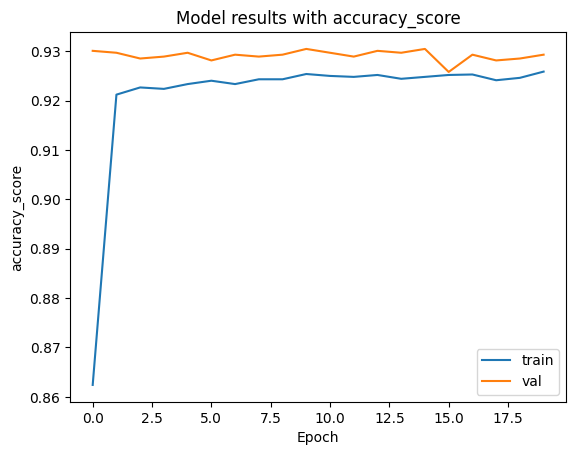

In [205]:
plot_metric(history, 'accuracy_score')

In [206]:
from sklearn import metrics


def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

# Завдання 6

Натренуйте модель для регресії

loss -- MSE

In [207]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_regression.parameters(), lr=1e-2)

history = train(model_regression, optimizer, loss_fn, credit_train_dl, credit_test_dl,
          metrics=[], metrics_name=None, epochs=20, device='cpu', task='regression')


train() called: model=Regression, opt=Adam(lr=0.010000), epochs=20, device=cpu

Epoch    1    0sec	loss:    1.6e+06	val_loss:   1.25e+06	
Epoch    2    0sec	loss:   1.55e+06	val_loss:   1.14e+06	
Epoch    3    0sec	loss:   1.38e+06	val_loss:   9.29e+05	
Epoch    4    0sec	loss:   1.22e+06	val_loss:   8.79e+05	
Epoch    5    0sec	loss:   1.21e+06	val_loss:   8.66e+05	
Epoch    6    0sec	loss:    1.2e+06	val_loss:   8.54e+05	
Epoch    7    0sec	loss:   1.18e+06	val_loss:   8.43e+05	
Epoch    8    0sec	loss:   1.18e+06	val_loss:   8.32e+05	
Epoch    9    0sec	loss:   1.16e+06	val_loss:   8.21e+05	
Epoch   10    0sec	loss:   1.15e+06	val_loss:   8.07e+05	
Epoch   11    0sec	loss:   1.15e+06	val_loss:   7.95e+05	
Epoch   12    0sec	loss:   1.12e+06	val_loss:    7.8e+05	
Epoch   13    0sec	loss:   1.11e+06	val_loss:   7.64e+05	
Epoch   14    0sec	loss:   1.09e+06	val_loss:   7.48e+05	
Epoch   15    0sec	loss:   1.08e+06	val_loss:   7.26e+05	
Epoch   16    0sec	loss:   1.05e+06	val_loss:   7.

# Завдання 7
Напишіть клас CreditModel
* init -- 3 атрибути
    * preprocessor
    * classificator
    * regressor

* predict -- робить прогноз у такому порядку
    * застосовує препроцесор
    * переводить дані в тензор
    * отримує ймовірність від класифікатора
    * якщо ймовірність нижче 50% -- повертає 0
    * якщо ймовірність вижче 50% -- отримує суму кредити від регресора та повертає(як число)

In [208]:
class CreditModel:
  def __init__(self, preprocessor, classificator, regressor):
    self.preprocessor = preprocessor
    self.classificator = classificator
    self.regressor = regressor

  def predict(self, X):
    X_preprocessor = self.preprocessor.transform(X)

    X = torch.tensor(X_preprocessor.values, dtype=torch.float32)
    if self.classificator(X).item() < 0.5:
      return 0

    with torch.no_grad():
      y_predict = self.regressor(X).item()

    return y_predict


In [209]:
mask = df.credit>0
X1 = df[mask].sample(1) #.drop(columns=["offer",	"credit"])
X1


,age,is_working,job,marital,education,balance,housing,loan,contact,campaign,poutcome,offer,credit
8940,27,yes,blue-collar,single,secondary,513,yes,yes,cellular,1,unknown,yes,190


In [210]:
model = CreditModel(preprocessor, model_clasification, model_regression)
model.predict(X1)

154.0624542236328

In [211]:
X = df.sample(1)

X

,age,is_working,job,marital,education,balance,housing,loan,contact,campaign,poutcome,offer,credit
5316,57,yes,technician,married,secondary,295,no,no,cellular,11,unknown,no,0


In [212]:
model.predict(X)

376.1695861816406